<a href="https://colab.research.google.com/github/YasirHabib/Deep-Learning-Advanced-Computer-Vision/blob/master/class_activation_maps_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

In [0]:
from keras.models import Model
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image

In [0]:
from glob import glob

In [39]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [0]:
path = '/content/gdrive/My Drive/Colab Notebooks/Deep Learning: Advanced Computer Vision/101_ObjectCategories/'

In [0]:
images = glob(path + '/*/*.jp*g')

In [42]:
total_images = len(images)
print("Total images:", total_images)

Total images: 4596


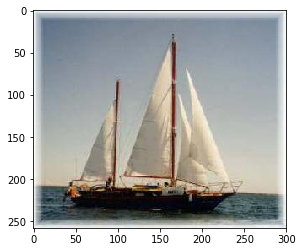

In [43]:
# look at an image for fun
plt.imshow(image.load_img(np.random.choice(images)))
plt.show()

In [0]:
# add preprocessing layer to the front of resnet
res = ResNet50(input_shape=(224, 224, 3), weights='imagenet', include_top=True)

In [45]:
# view the structure of the model
# if you want to confirm we need activation_49
res.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

In [46]:
# make a model to get output before flatten
partial_model = Model(
    inputs=res.input,
    outputs=res.layers[-3].output
)
partial_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

In [47]:
# get the feature map weights
final_dense = res.get_layer('fc1000')
W = final_dense.get_weights()[0]
print(W.shape)

(2048, 1000)


[('n02317335', 'starfish', 0.89660656), ('n03530642', 'honeycomb', 0.0131644765), ('n13040303', 'stinkhorn', 0.0068460735), ('n03598930', 'jigsaw_puzzle', 0.0038577612), ('n02319095', 'sea_urchin', 0.0034412402)]


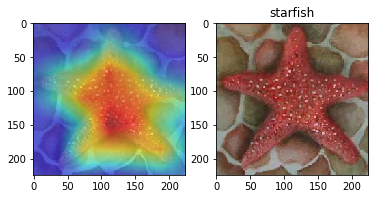

Continue? (Y/n)y
[('n02346627', 'porcupine', 0.75612324), ('n02363005', 'beaver', 0.05877223), ('n02361337', 'marmot', 0.048437245), ('n02442845', 'mink', 0.009949389), ('n09256479', 'coral_reef', 0.007439928)]


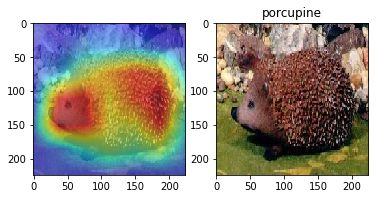

Continue? (Y/n)n


In [48]:
while True:
  img = image.load_img(np.random.choice(images), target_size=(224, 224))
  x = preprocess_input(np.expand_dims(img, 0))
  fmaps = partial_model.predict(x)[0] # 7 x 7 x 2048

  # get predicted class
  probs = res.predict(x)
  classnames = decode_predictions(probs)[0]
  print(classnames)
  classname = classnames[0][1]
  pred = np.argmax(probs[0])

  # get the 2048 weights for the relevant class
  w = W[:, pred]

  # "dot" w with fmaps
  cam = fmaps.dot(w)

  # upsample to 224 x 224
  # 7 x 32 = 224
  cam = sp.ndimage.zoom(cam, (32, 32), order=1)

  plt.subplot(1,2,1)
  plt.imshow(img, alpha=0.8)
  plt.imshow(cam, cmap='jet', alpha=0.5)
  plt.subplot(1,2,2)
  plt.imshow(img)
  plt.title(classname)
  plt.show()

  ans = input("Continue? (Y/n)")
  if ans and ans[0].lower() == 'n':
    break